In [1]:
#!pip install tensorflow --upgrade
#!pip install tf-models-official
#!pip install tensorflow-text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow import keras
print(tf.__version__) # 2.6.0

import warnings
warnings.filterwarnings('ignore')

2.6.0


# 1. Text and Document Feature Extraction
### 1.1. Introduction to data preprocessing
Data goes through a series of steps during preprocessing:
   - **Data cleaning**: is the process of
        + Detecting and correcting (removing) corrupt or inaccurate records from a record set, table or database
        + Identifying incomplete, incorrect, inaccurate or irrelevant parts of data
        + Replacing, modifying or deleting the dirty or coarse data. 
        
   A common data cleansing practice is data enhancement, where data is made more complete by adding related information and data editing that is the process involving the review and adjustment of collected survey data, to control the quality of the collected data.
    
   - **Data wrangling**: Sometimes referred to as data munging, is the process of transforming and mapping data from one “raw” data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics. This may include further munging, data visualization, data aggregation, training a statistical model...
   
   - **Data reduction or instance/feature selection and extraction**: Approaches for instance selection can be applied for reducing the original dataset to a manageable volume, leading to a reduction of the computational resources that are necessary for performing the learning process and might improve the accuracy in classification problems.

### 1.2. Text Cleaning and Pre-processing
Text preprocessing method is used to preprocess your text simply means to bring your text into a form that is predictable and analyzable for your task. Text preprocessing is task-specific.
* **Must Do**:
    - Noise removal
    - Lowercasing (can be task dependent in some cases)
* **Should Do**:
    - Simple normalization – (e.g. standardize near identical words)
* **Task Dependent**:
    - Advanced normalization (e.g. addressing out-of-vocabulary words)
    - Stop-word removal
    - Stemming / Lemmatization
    - Text enrichment / Augmentation
* **Additional considerations**:
    - Handling large documents and large collections of text documents that do not fit into memory.
    - Extracting text from markup like HTML, PDF or other structured document formats.
    - Trans-literation of characters from other languages into English.
    - Handling of domain specific words, phrases and acronyms.

Below are examples of some techniques.
- **Tokenization**: is the process of breaking down a stream of text into words, phrases, symbols, or any other meaningful elements called tokens. The main goal of this step is to extract individual words in a sentence.
    
    + You could use spaCy (or gensim, nltk). Recommend to use spaCy because it's one of the most versatile and widely used libraries in NLP.
    + You could also use tf.text with BERTTokenizer for this tasks (and more - full pipeline in tensorflow)

- **Stop words**: 
    In spaCy, you could get the complete list via:
    `from spacy.lang.en.stop_words import STOP_WORDS`

In [2]:
import spacy # don't --> do and n't

text = 'today is the hottest day of this month'
nlp = spacy.load('en_core_web_sm')
tokens = nlp(text)
token_list, filtered_sentence = [], []
for token in tokens:
    token_list.append(token.text)
    if not token.is_stop: # you could also customize stop_words like this: nlp.vocab[word] = False
        filtered_sentence.append(token.text)

print(token_list)
print(filtered_sentence)   

['today', 'is', 'the', 'hottest', 'day', 'of', 'this', 'month']
['today', 'hottest', 'day', 'month']


- **Capitalization**: To reduce the problem space, the most common approach is to reduce everything to lower case. This brings all words in a document in same space, but it often changes the meaning of some words, such as "US" to "us" where first one represents the United States of America and second one is a pronoun. To solve this, slang and abbreviation converters can be applied.
- **Slang and Abbreviations**: An abbreviation is a shortened form of a word, such as SVM stand for Support Vector Machine. Slang is a version of language that depicts informal conversation or text that has different meaning, such as "lost the plot", it essentially means that 'they've gone mad'. Common method to deal with these words is converting them to formal language.
- **Noise removal**: remove punctuations or special characters - this is one of the most essential text preprocessing steps and also highly domain dependent. There are various ways to remove noise, it all depends on which domain you are working in and what entails noise for your task. This includes:
    + punctuation removal
    + special character removal
    + numbers removal
    + html formatting removal
    + domain specific keyword removal (e.g. ‘RT’ for retweet)
    + source code removal
    + header removal and more. 

In [3]:
import re

def text_cleaner(text):
    rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''},  # remove spaces at the beginning
        {r'(\\u[0-9A-Fa-f]+)': r''}, # remove unidecode with null
        {r'[^\x00-\x7f]': r''}, # remove unidecode with null
        {r'((www\.[^\s]+)|(https?://[^\s]+))': r'url'}, # replace url with "url"
        {'@[^\s]+': 'atUser'}, # replace @ with "atUser"
        {r'#([^\s]+)': r'\1'}, # remove hashtag before word (\1 mean group 1)
        {r'(\!)\1+': ' multiExclamation '}, # replace multiple !
        {r'(\?)\1+': ' multiQuestion '}, # replace multiple ?
        {r'(\.)\1+': ' multiStop '}, # replace multiple .
    ]
    for rule in rules:
        for (k, v) in rule.items(): # k = rule, v = output
            text = re.sub(k, v, text) 
    # Remove number
    text = ''.join([i for i in text if not i.isdigit()])

    # Replaces contractions from a string to their equivalents
    contraction_patterns = [
        (r'won\'t', 'will not'), 
        (r'can\'t', 'cannot'), 
        (r'i\'m', 'i am'), 
        (r'ain\'t', 'is not'), 
        (r'(\w+)\'ll', '\g<1> will'), 
        (r'(\w+)n\'t', '\g<1> not'),
        (r'(\w+)\'ve', '\g<1> have'), 
        (r'(\w+)\'s', '\g<1> is'), 
        (r'(\w+)\'re', '\g<1> are'), 
        (r'(\w+)\'d', '\g<1> would'), 
        (r'&', 'and'), 
        (r'dammit', 'damn it'), 
        (r'dont', 'do not'), 
        (r'wont', 'will not') 
    ]
    for (pattern, repl) in contraction_patterns:
        text = re.sub(pattern, repl, text)

    # Remove Emoticons
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', 
                  '', text)
    
    return text.rstrip().lower()

some_text_from_twitter = '''?RT @justinbiebcr: The bigger the better....if you know what I mean ;). 
"Iran, with its unity and God's grace, will punch the arrogance (West) 22nd of Bahman (Feb 11) in a way that will leave them stunned,"
#4WordsOnObamasHand Don't Say The N-Word. @russmarshalek Sold! Would love to be your crazyass big sis -- how could I say no?! Cannot believe I broke or minimally battered my toe --
i need money! i need new car!!! jesus...somebody please buy my old car :DDD'''

text_cleaner(some_text_from_twitter)

'?rt atuser the bigger the better multistop if you know what i mean . "iran, with its unity and god is grace, will punch the arrogance (west) nd of bahman (feb ) in a way that will leave them stunned," wordsonobamashand do not say the n-word. atuser sold! would love to be your crazyass big sis -- how could i say no?! cannot believe i broke or minimally battered my toe -- i need money! i need new car multiexclamation  jesus multistop somebody please buy my old car ddd'

- **Spelling corretion**: such as hashing-based and context-sensitive spelling correction techniques, or spelling correction using trie and damerau-levenshtein distance bigram

In [4]:
!pip3 install autocorrect
from autocorrect import spell 

print(spell(u'caaaar'))
print(spell(u'mussage'))
print(spell(u'survice'))
print(spell(u'hte'))

autocorrect.spell is deprecated,             use autocorrect.Speller instead
aaaaaa
autocorrect.spell is deprecated,             use autocorrect.Speller instead
message
autocorrect.spell is deprecated,             use autocorrect.Speller instead
service
autocorrect.spell is deprecated,             use autocorrect.Speller instead
the


- **Stemming**: modifying a word to obtain its variants using different linguistic processeses like affixation (addition of affixes). E.g. changed, changes, changing, changer --> chang but not change as in Lemmatization, so it might not be useful as Lemmatization (but you also find it via nltk library)
- **Lemmatization**: the process of eliminating redundant prefix or suffix of a word and extract the *base word* (lemma).

More linguistic features (such as POS, is_alpha...) about NLP could be found at spaCy website: https://spacy.io/usage/linguistic-features

In [5]:
print([token.lemma_ for token in tokens])

['today', 'be', 'the', 'hot', 'day', 'of', 'this', 'month']


- Some examples with Web data

In [6]:
import requests

# a. Reading data from static web
url = 'http://www.gutenberg.org/files/2554/2554-0.txt'
raw = requests.get(url).text

print('-'*50, '\n', 'STATIC WEB', '\n')
print(type(raw), len(raw))
print(raw[:75])

# New decoding
new_r = raw.encode().decode('utf-8-sig')
print(new_r[:75])

# b. Dealing with HTML
url = "http://news.bbc.co.uk/2/hi/health/2284783.stm"
html = requests.get(url).text
print('-'*50, '\n', 'HTML', '\n')
print(html[:60])

# Get text out of HTML
from bs4 import BeautifulSoup # !pip install beautifulsoup4 

raw = BeautifulSoup(html, 'html.parser').get_text()
tokens = [token.text for token in nlp(raw)]
print(tokens[:50])
print(raw[:50])

# + Deal with blogosphere data
import feedparser # !pip install feedparser
llog = feedparser.parse("http://languagelog.ldc.upenn.edu/nll/?feed=atom")
print('-'*50, '\n', 'BLOG', '\n')
print(llog['feed']['title'])
print(len(llog.entries))

post = llog.entries[2]
print(post.title)

content = post.content[0].value
print(content[:70])

raw = BeautifulSoup(content, 'html.parser').get_text()
print(raw)

-------------------------------------------------- 
 STATIC WEB 

<class 'str'> 1201520
ï»¿The Project Gutenberg eBook of Crime and Punishment, by Fyodor Dostoevsk
ï»¿The Project Gutenberg eBook of Crime and Punishment, by Fyodor Dostoevsk
-------------------------------------------------- 
 HTML 

<!doctype html public "-//W3C//DTD HTML 4.0 Transitional//EN
['\n\n\n', 'BBC', 'NEWS', '|', 'Health', '|', 'Blondes', "'", 'to', 'die', 'out', 'in', '200', 'years', "'", '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n', 'NEWS', '\n\xa0\xa0', 'SPORT', '\n\xa0\xa0', 'WEATHER', '\n\xa0\xa0', 'WORLD', 'SERVICE', '\n\n\xa0\xa0', 'A', '-', 'Z', 'INDEX', '\xa0\n\n\xa0\xa0', 'SEARCH', '\xa0\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\r\n    \xa0', 'You', 'are', 'in', ':', '\xa0', 'Health', '\xa0\r\n    \r\n    \r\n\n\n\n\n\n\n\n\n\n\n\n', 'News', 'Front', 'Page', '\n\n\n\n\n\n', 'Africa', '\n\n\n', 'Americas', '\n\n\n', 'Asi

* **Others: Extracting Text from PDF, MSWord and other Binary Formats**

ASCII text and HTML text are human readable formats. Text often comes in binary formats — like PDF and MSWord — that can only be opened using specialized software. Third-party libraries such as **pypdf** and **pywin32** provide access to these formats. Extracting text from multi-column documents is particularly challenging. For once-off conversion of a few documents, it is simpler to open the document with a suitable application, then save it as text to your local drive, and access it as described below. If the document is already on the web, you can enter its URL in Google's search box. The search result often includes a link to an HTML version of the document, which you can save as text.

### 1.3. Word Embedding
Different word embedding procedures have been proposed to translate these unigrams into consummable input for machine learning algorithms. A very simple way to perform such embedding is term-frequency~(TF) where each word will be mapped to a number corresponding to the number of occurrence of that word in the whole corpora. The other term frequency functions have been also used that represent word-frequency as Boolean or logarithmically scaled number. Here, each document will be converted to a vector of same length containing the frequency of the words in that document. Although such approach may seem very intuitive but it suffers from the fact that particular words that are used very commonly in language literature might dominate this sort of word representations.

- **Word2Vec**: original & reference from https://code.google.com/p/word2vec/

 Given a text corpus, the word2vec tool learns a vector for every word in the vocabulary using the Continuous Bag-of-Words or the Skip-Gram neural network architectures. 

 The user should specify the following: desired vector dimensionality (size of the context window for either the Skip-Gram or the Continuous Bag-of-Words model), training algorithm (hierarchical softmax and / or negative sampling) or threshold for downsampling the frequent words, number of threads to use, format of the output word vector file (text or binary).

- **GLoVe**: Global Vectors for Word Representation

 An implementation of the GloVe model for learning word representations is provided, and describe how to download web-dataset vectors or train your own. See the project page at https://nlp.stanford.edu/projects/glove/ for more information on glove vectors.

- **Contextualized Word Representations**

 ELMo is a deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). These word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus. They can be easily added to existing models and significantly improve the state of the art across a broad range of challenging NLP problems, including question answering, textual entailment and sentiment analysis.

 ELMo representations are:
  - Contextual: The representation for each word depends on the entire context in which it is used.
  - Deep: The word representations combine all layers of a deep pre-trained neural network.
  - Character based: ELMo representations are purely character based, allowing the network to use morphological clues to form robust representations for out-of-vocabulary tokens unseen in training.

  You could use ELMo via two ways:
   - Easy version at https://tfhub.dev/google/elmo/2
   - Some other pretrained models: https://allennlp.org/elmo - including a JSON formatted "options" file with hyperparameters and a hdf5 formatted file with the model weights. There are three ways to integrate ELMo representations into a downstream task, depending on your use case.
    - Compute representations on the fly from raw text using character input. This is the most general method and will handle any input text. It is also the most computationally expensive. This method is necessary for evaluating at test time on unseen data (e.g. public SQuAD leaderboard)
    - Precompute and cache the context independent token representations, then compute context dependent representations using the biLSTMs for input data. This method is less computationally expensive then #1, but is only applicable with a fixed, prescribed vocabulary. This approach is a good compromise for large datasets where the size of the file in is unfeasible (SNLI, SQuAD)
    - Precompute the representations for your entire dataset and save to a file.
It is a good choice for smaller datasets or in cases where you'd like to use ELMo in other frameworks.

   In all cases, the process roughly follows the same steps. First, create a Batcher (or TokenBatcher for #2) to translate tokenized strings to numpy arrays of character (or token) ids. Then, load the pretrained ELMo model (class BidirectionalLanguageModel). Finally, for steps #1 and #2 use weight_layers to compute the final ELMo representations. For #3, use BidirectionalLanguageModel to write all the intermediate layers to a file.

* **FastText**: fastText is a library for efficient learning of word representations and sentence classification. Reference at https://github.com/facebookresearch/fastText and https://fasttext.cc/docs/en/english-vectors.html
 - Features: 
   - Recent state-of-the-art English word vectors.
   - Word vectors for 157 languages trained on Wikipedia and Crawl.
   - Models for language identification and various supervised tasks.

### 1.4. Weighted Words
- Term frequency is Bag of words that is one of the simplest techniques of text feature extraction. This method is based on counting number of the words in each document and assign it to feature space.
- Term Frequency-Inverse Document Frequency
Although tf-idf tries to overcome the problem of common terms in document (through lowering weight by divide the number of documents contain these terms), it still suffers from some other descriptive limitations. Namely, tf-idf cannot account for the **similarity between words** in the document since each word is presented as an index. In the recent years, with development of more complex models, such as neural nets, new methods has been presented that can **incorporate concepts**, such as **similarity of words** and **part of speech tagging**. This work uses, **word2vec and Glove**, two of the most common methods that have been successfully used for deep learning techniques.

### 1.5. Comparison of Feature Extraction Techniques
Reference more at https://github.com/kk7nc/Text_Classification#comparison-of-feature-extraction-techniques

There are 4 main performance problems with these techniques:
 - Syntactic (capture the position in the text): TF-IDF could not solve this
 - Semantics (capture meaning in the text): TF-IDF could not solve this
 - Polysemy (meaning of the word from the text - context): only ELMo (Contextualized Word Representations) could solve this
 - Out-of-vocabulary words from corpus: FastText and TF-IDF support this via n-gram hyperparameters

# 2. Text classification techniques

* Data preparation - IMDB dataset


In [7]:
X_train, y_train = tfds.load('imdb_reviews', split='train', batch_size=-1, as_supervised=True)
X_test, y_test = tfds.load('imdb_reviews', split='test', batch_size=-1, as_supervised=True)
# batch_size=-1 for full dataset in single batch

raw_train_ds = tfds.load('imdb_reviews', split='train', as_supervised=True).take(1000) 
raw_test_ds = tfds.load('imdb_reviews', split='test', as_supervised=True).take(1000)

print(X_train.shape, X_test.shape)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


(25000,) (25000,)


### 2.1. Non-neural network techniques

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=1000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train.numpy()).toarray() # toarray used for later use in DNN training
X_test_tfidf = vectorizer.transform(X_test.numpy()).toarray()

def benchmark(clf, nn=False, embedding=True, train_data=raw_train_ds, test_data=raw_test_ds, n_epochs=5):
    if nn:
        if not embedding:
            clf.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), epochs=n_epochs, batch_size=128)
            pred = (clf.predict(X_test_tfidf) > 0.5).astype('int32')
            print('Accuracy: ', round(metrics.accuracy_score(y_test, pred), 2))
        else:
            clf.fit(train_data, validation_data=test_data, epochs=n_epochs, batch_size=128)
            print('Loss, Accuracy: ', clf.evaluate(test_data))
    else:
        clf.fit(X_train_tfidf, y_train)
        pred = clf.predict(X_test_tfidf)
        
        accuracy = round(metrics.accuracy_score(y_test, pred), 2)
        clf_descr = str(clf).split('(')[0]
        return clf_descr, accuracy

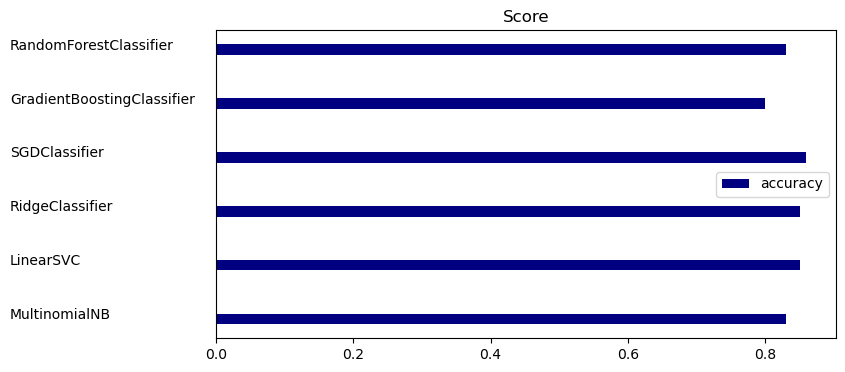

In [9]:
list_clf = [
            MultinomialNB(alpha=.01),
            LinearSVC(penalty='l2', dual=False, tol=1e-3),
            RidgeClassifier(tol=1e-2, solver="auto"),
            SGDClassifier(alpha=.0001, max_iter=50, penalty='l2'),
            GradientBoostingClassifier(),
            RandomForestClassifier(),
]

results = [benchmark(clf) for clf in list_clf]

# Aggregate results
indices = np.arange(len(results))
update_results = [[x[i] for x in results] for i in range(2)] # convert to list of lists

clf_names, accuracy = update_results

plt.figure(figsize=(8, 4))
plt.title("Score")
plt.barh(indices, accuracy, .2, label="accuracy", color='navy')
plt.yticks(())
plt.legend(loc='best')

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

### 2.2. Deep Neural Networks
Deep Neural Networks architectures are designed to learn through multiple connection of layers where each single layer only receives connection from previous and provides connections only to the next layer in hidden part.

The input is a connection of feature space (as feature_extraction with first hidden layer). For Deep Neural Networks (DNN), input layer could be tf-idf, word embedding or etc.
The output layer houses neurons equal to the number of classes for multi-class classification and only one neuron for binary classification.

- Deep Neural Networks

In [10]:
def create_dnn(): # without embedding layer to compare with previous results
    model = keras.models.Sequential()
    # model.add(keras.Input(shape=(X_train_tfidf.shape[1],)))
    # or model.add(keras.layers.InputLayer(input_shape=[None, 1]))
    # or input_shape=[None, 1] in the next layers (without batch_size)
    model.add(keras.layers.Dense(64, input_dim=1000, activation='relu'))

    n_layers = 2
    for i in range(0, n_layers):
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.5))    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model 

model = create_dnn()
benchmark(model, nn=True, embedding=False)

Epoch 1/5
196/196 [==============================] - 2s 8ms/step - loss: 0.4674 - accuracy: 0.7839 - val_loss: 0.3326 - val_accuracy: 0.8541
Epoch 2/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3336 - accuracy: 0.8655 - val_loss: 0.3304 - val_accuracy: 0.8524
Epoch 3/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3110 - accuracy: 0.8728 - val_loss: 0.3268 - val_accuracy: 0.8543
Epoch 4/5
196/196 [==============================] - 1s 6ms/step - loss: 0.2844 - accuracy: 0.8841 - val_loss: 0.3339 - val_accuracy: 0.8520
Epoch 5/5
196/196 [==============================] - 1s 6ms/step - loss: 0.2451 - accuracy: 0.9020 - val_loss: 0.3604 - val_accuracy: 0.8501
Accuracy:  0.85


- Embedding layers

In [11]:
import re, string

# Model constants
max_features = 1000
embedding_dim = 128
sequence_length = 200

def word_embedding():
    
    # Convert text to word embedding
    def custom_standardization(X_batch):
        X_batch = tf.strings.lower(X_batch)
        X_batch = tf.strings.regex_replace(X_batch, "<br />", " ")
        # Some more preprocessing
        #X_batch = tf.strings.substr(X_batch, 0, 300)
        #X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
        #X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
        #X_batch = tf.strings.split(X_batch)
        #return X_batch.to_tensor(default_value=b"<pad>"), y_batch
        return tf.strings.regex_replace(X_batch, "[%s]" % re.escape(string.punctuation), "")

    vectorizer = tf.keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int", # normalize, split, and map strings to integers
        output_sequence_length=sequence_length, # explicit sequence length, since the CNNs won't support ragged sequences
    )
    # vectorizer transforms strings into vocabulary indices

    text_ds = raw_train_ds.map(lambda x, y: x) # make a text-only dataset (no labels)
    vectorizer.adapt(text_ds) # call `adapt` to create the vocabulary. 
    # Don't have to batch, but for very large datasets this means you're not keeping spare copies of the dataset in memory.
    # Two options to vectorize the data
    # (+) Option 1: Make it part of the model, so as to obtain a model that processes raw strings, like this:
    #text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    #x = vectorize_layer(text_input)
    #x = layers.Embedding(max_features + 1, embedding_dim)(x) 
    #...
    # (+) Option 2: Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that 
    # expects integer sequences as inputs. This  enables you to do asynchronous CPU processing and buffering of your data when training on GPU.
    def vectorize_text(text, label):
        text = tf.expand_dims(text, -1)
        return vectorizer(text), [label]

    # Vectorize the data. Do async prefetching / buffering of the data for best performance on GPU.
    train_ds = raw_train_ds.map(vectorize_text).cache().prefetch(buffer_size=10)
    # or vectorizer(np.array([[s] for s in train_samples])).numpy() for raw_text
    test_ds = raw_test_ds.map(vectorize_text).cache().prefetch(buffer_size=10)
    
    return train_ds, test_ds, vectorizer

def word_pretrain_embedding(path_to_glove_file, vectorizer):
    
    # Convert text to word embedding (Using pre-trained word-embedding GloVe)
    embeddings_index = {}
    with open(path_to_glove_file) as f: # path_to_glove_file - e.g. glove.6B.100d.txt
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))
    # prepare a corresponding embedding matrix that we can use in a Keras Embedding layer
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
    hits = 0
    misses = 0

    test = ["the", "cat", "sat", "on", "the", "mat"]
    print([word_index[w] for w in test])

    # Prepare embedding matrix
    embedding_matrix = np.zeros((max_features, embedding_dim)) # max_features or len(word_index) + len(oov)
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    embedding_layer = keras.layers.Embedding(
        max_features,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix), # adding this compare to no pre-trained model
        trainable=False, #  keep the embeddings fixed (we don't want to update them during training)
    )
    
    return embedding_layer

train_ds, test_ds, vectorizer = word_embedding()

* For pretraining 

In [12]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip # 822 MB
#!unzip -q glove.6B.zip
#path_to_glove_file = os.path.join(os.path.expanduser("~"), ".keras/datasets/glove.6B.100d.txt")
#pretrained_embedding_layer = word_pretrain_embedding(path_to_glove_file=, vectorizer=vectorizer)
#model = create_cnn(pretrained=True)

- Convolutional Neural Network

In [13]:
def create_cnn(pretrained=False, n_filters=64, kernel_size=5):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(None,), dtype="int64")) # A integer input for vocab indices.

    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    if not pretrained: 
        model.add(keras.layers.Embedding(max_features, embedding_dim))
    else:
        model.add(pretrained_embedding_layer)
    model.add(keras.layers.Dropout(0.5))

    # Conv1D + global max pooling
    n_layers = 2
    for _ in range(n_layers):
        model.add(keras.layers.Conv1D(n_filters, kernel_size, padding="valid", activation="relu", strides=2))
    model.add(keras.layers.GlobalMaxPooling1D())
    
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1, activation="sigmoid", name="predictions"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

model = create_cnn()
benchmark(model, nn=True, embedding=True, train_data=train_ds, test_data=test_ds, n_epochs=10)

Epoch 1/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6977 - accuracy: 0.4760 - val_loss: 0.6924 - val_accuracy: 0.5160
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6943 - accuracy: 0.5340 - val_loss: 0.6699 - val_accuracy: 0.6240
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6452 - accuracy: 0.6400 - val_loss: 0.6499 - val_accuracy: 0.6390
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4639 - accuracy: 0.7980 - val_loss: 0.6395 - val_accuracy: 0.6900
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3056 - accuracy: 0.8810 - val_loss: 0.8048 - val_accuracy: 0.6830
Epoch 6/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1680 - accuracy: 0.9540 - val_loss: 0.9613 - val_accuracy: 0.6970
Epoch 7/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1243 - accuracy: 0.9530 - val_loss: 1.2305 - val_accuracy:

- RNN: 

    Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. For more information about implementation of stateful RNN, check at https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse

In [14]:
def create_rnn(pretrained=False):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(None,), dtype="int64")) # A integer input for vocab indices.

    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    if not pretrained: 
        model.add(keras.layers.Embedding(max_features, embedding_dim))
    else:
        model.add(pretrained_embedding_layer)
    model.add(keras.layers.Dropout(0.5))

    # RNN here!!!
    model.add(keras.layers.SimpleRNN(32, return_sequences=True))
    model.add(keras.layers.SimpleRNN(32))
    
    model.add(keras.layers.Dense(1, activation="sigmoid", name="predictions"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

def create_gru(pretrained=False):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(None,), dtype="int64")) # A integer input for vocab indices.

    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    if not pretrained: 
        model.add(keras.layers.Embedding(max_features, embedding_dim))
    else:
        model.add(pretrained_embedding_layer)
    model.add(keras.layers.Dropout(0.5))

    # GRU / LSTM
    n_layers = 2
    for i in range(n_layers):
        model.add(keras.layers.GRU(32, return_sequences=True, recurrent_dropout=0.2)) 
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.GRU(32, recurrent_dropout=0.2)) # the last layer do not return sequence
    model.add(keras.layers.Dense(1, activation="sigmoid", name="predictions"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

print('-'*50, '\n', 'RNN: ')
benchmark(create_rnn(), nn=True, embedding=True, train_data=train_ds, test_data=test_ds, n_epochs=3)

print('-'*50, '\n', 'GRU: ')
benchmark(create_gru(), nn=True, embedding=True, train_data=train_ds, test_data=test_ds, n_epochs=3)

-------------------------------------------------- 
 RNN: 
Epoch 1/3
1000/1000 [==============================] - 151s 149ms/step - loss: 0.7150 - accuracy: 0.4890 - val_loss: 0.7023 - val_accuracy: 0.5030
Epoch 2/3
1000/1000 [==============================] - 128s 128ms/step - loss: 0.6992 - accuracy: 0.5520 - val_loss: 0.6964 - val_accuracy: 0.5150
Epoch 3/3
1000/1000 [==============================] - 19s 19ms/step - loss: 0.7710 - accuracy: 0.5210
Loss, Accuracy:  [0.7709929347038269, 0.5210000276565552]
-------------------------------------------------- 
 GRU: 
Epoch 1/3
1000/1000 [==============================] - 674s 667ms/step - loss: 0.6978 - accuracy: 0.4880 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 2/3
1000/1000 [==============================] - 676s 676ms/step - loss: 0.6958 - accuracy: 0.5070 - val_loss: 0.6944 - val_accuracy: 0.4980
Epoch 3/3
1000/1000 [==============================] - 67s 67ms/step - loss: 0.7486 - accuracy: 0.4830
Loss, Accuracy:  [0.7485521435

- RCNN:

    Recurrent Convolutional Neural Networks (RCNN) is also used for text classification. The main idea of this technique is capturing contextual information with the recurrent structure and constructing the representation of text using a convolutional neural network. This architecture is a combination of RNN and CNN to use advantages of both technique in a model.

In [15]:
def create_rcnn(pretrained=False, n_filters=32, kernel_size=3):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(None,), dtype="int64")) # A integer input for vocab indices.

    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    if not pretrained: 
        model.add(keras.layers.Embedding(max_features, embedding_dim))
    else:
        model.add(pretrained_embedding_layer)
    model.add(keras.layers.Dropout(0.5))
    
    n_layers = 2
    for _ in range(n_layers):
        model.add(keras.layers.Conv1D(n_filters, kernel_size, padding="valid", activation="relu", strides=2))
        model.add(keras.layers.MaxPooling1D(pool_size=2)) # move GlobalMaxPooling layers down
    # Global max pooling layer return a fixed-length output vector for each example by averaging over the sequence dimension. 
    # This allows the model to handle input of variable length, in the simplest way possible.
    # Global max pooling = ordinary max pooling layer with pool size equals to the size of the input 
    # (minus filter size + 1, to be precise)    
    
    # GRU / LSTM
    for _ in range(n_layers):
        model.add(keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.2))
        model.add(keras.layers.Dropout(0.5)) #or drop_out=0.5 in the previous layers
    model.add(keras.layers.GlobalMaxPooling1D())

    model.add(keras.layers.Dense(1, activation="sigmoid", name="predictions"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

model = create_rcnn()
benchmark(create_rcnn(), nn=True, embedding=True, train_data=train_ds, test_data=test_ds, n_epochs=5)

Epoch 1/5
1000/1000 [==============================] - 46s 41ms/step - loss: 0.6954 - accuracy: 0.4770 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 2/5
1000/1000 [==============================] - 41s 41ms/step - loss: 0.6942 - accuracy: 0.5030 - val_loss: 0.6896 - val_accuracy: 0.5040
Epoch 3/5
1000/1000 [==============================] - 39s 39ms/step - loss: 0.6466 - accuracy: 0.6360 - val_loss: 0.5904 - val_accuracy: 0.7240
Epoch 4/5
1000/1000 [==============================] - 41s 41ms/step - loss: 0.4039 - accuracy: 0.8210 - val_loss: 0.5360 - val_accuracy: 0.7340
Epoch 5/5
1000/1000 [==============================] - 8s 7ms/step - loss: 0.5272 - accuracy: 0.7440
Loss, Accuracy:  [0.5271626710891724, 0.7440000176429749]


* **Export an end-to-end model**

We may want to export a Model object that takes as input a string of arbitrary length, rather than a sequence of indices. It would make the model much more portable, since you wouldn't have to worry about the input preprocessing pipeline.

In [16]:
inputs = keras.Input(shape=(1,), dtype="string")
indices = vectorizer(inputs)
outputs = model(indices) # model = create_cnn().fit(train_ds, validation_data=test_ds, n_epochs=5)
end_to_end_model = keras.Model(inputs, outputs)

# Specific case
prob = end_to_end_model.predict(
    [["the worst movie ever"]]
)

prob.argmax(axis=-1) # class name

array([0])

- Some pretrained models

In [17]:
# a. Pretrained model with BERT (Tensorflow Hub)
# Reference more at: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}
map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}') # the input is truncated to 128 tokens - could be customized
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}') # all zero for single sentence input. 
# For a multiple sentence input, it would have one number for each input

bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# Pooled Output: each input sequence as a whole. The shape is [batch_size, H] (as an embedding for the entire movie review)
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# Sequence Output: each input token in the context. The shape is [batch_size, seq_length, H]. 
# You can think of this as a contextual embedding for every token in the movie review.
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

def create_model_tfhub():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

# Could check that the model runs with the output of the preprocessing model.
model = create_model_tfhub()
bert_raw_result = model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

# For looking at model's architecture
#!pip install pydot graphviz
tf.keras.utils.plot_model(model)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626287   0.9928098  -0.18611833  0.3667385   0.1523368   0.65504456
  0.9681154  -0.9486271   0.00216172 -0.987773    0.06842685 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946376  0.3432126   0.3323155  ...  0.21300781  0.7102078
  -0.05771124]
 [-0.2874204   0.31981033 -0.23018603 ...  0.58455133 -0.21329767
   0.7269206 ]
 [-0.66157013  0.68876886 -0.8743305  ...  0.10877283 -0.2617

In [18]:
# pretrained model requires batched data -- the accuracy is very low since I've just take only 1000 samples
update_train_ds = raw_train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
update_test_ds = raw_test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

benchmark(create_model_tfhub(), nn=True, embedding=True, train_data=update_train_ds, test_data=update_test_ds, n_epochs=3)

Epoch 1/3
32/32 [==============================] - 118s 3s/step - loss: 7.4308 - accuracy: 0.5120 - val_loss: 7.6704 - val_accuracy: 0.4970
Epoch 2/3
32/32 [==============================] - 110s 3s/step - loss: 7.4721 - accuracy: 0.5100 - val_loss: 7.6704 - val_accuracy: 0.4970
Epoch 3/3
32/32 [==============================] - 26s 811ms/step - loss: 7.6704 - accuracy: 0.4970
Loss, Accuracy:  [7.67036771774292, 0.4970000088214874]


Running the following cells will take a bit longer to run and the result accuracy is approximately 0.5, so I just introduce this implementation and ignore to run it.

In [ ]:
# b. Transformers
# for Switch Transformers, reference at https://keras.io/examples/nlp/text_classification_with_switch_transformer/
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.5):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.models.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(dropout)
        self.dropout2 = keras.layers.Dropout(dropout)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

embedding_dim = 128
num_heads = 2 # number of attention head
ff_dim = 32 # hidden layer size in feed forward network inside transformer

def create_transformers(pretrained=False):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(None,), dtype="int64")) # A integer input for vocab indices.

    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    if not pretrained: 
        model.add(keras.layers.Embedding(max_features, embedding_dim))
    else:
        model.add(pretrained_embedding_layer)
    model.add(keras.layers.Dropout(0.5))

    # Transformers
    model.add(TransformerBlock(embedding_dim, num_heads, ff_dim))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(1, activation="sigmoid", name="predictions")) # == Dense(2, activation="softmax")
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # sparse_categorical_crossentropy

    return model

benchmark(create_transformers(), nn=True, embedding=False, train_data=train_ds, test_data=test_ds, n_epochs=1)

In [ ]:
# c. Another implementation from transformers repository
# For finetuning, reference at https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb
!pip install transformers
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

model.fit(train_ds, validation_data=test_ds, epochs=1)

In [ ]:
# For inference
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

reloaded_model = tf.saved_model.load(saved_model_path)
def print_my_examples(inputs, results):
    result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

For more information to optimize performance, coding..., reference at https://www.tensorflow.org/guide

### 2.3. Comparison Text classification models
* Non-neural network:
    - Pros:
        + Work well with small dataset
        + Computational complexity is cheap & faster
        + Implementation is much easier
        + Interpretability: available, but might loss with some complex algorithms such as bagging, boosting
    - Cons:
        + Scalability: small-scale
* Deep Learning:
    - Pros:
        + Flexible with features design (reduces the need for feature engineering, one of the most time-consuming parts of machine learning practice)
        + Architecture that can be adapted to new problems
        + Can deal with complex input-output mappings: End-to-End architecture
        + Can easily handle online learning (It makes it very easy to re-train the model when newer data becomes available)
        + Parallel processing capability (It can perform more than one job at the same time)
    - Cons:
        + Requires a large amount of data (if you only have small sample text data, deep learning is unlikely to outperform other approaches)
        + Problem: complex input-output mappings
        + Extremely computationally expensive to train
        + Model interpretability is hard
        + Finding an efficient architecture and structure is still the main challenge of this technique

# 3. Others
### 3.1. Data downloading & preparation
Exploit libraries: `keras.utils & pathlib`. E.g. download the Newsgroup20 data


In [19]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

# Let's take a look at the data
import os
import pathlib

data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])

print(open(data_dir / "comp.graphics" / "38987").read()) # very helpful with pathlib lib

Number of directories: 20
Directory names: ['comp.graphics', 'talk.religion.misc', 'rec.autos', 'comp.windows.x', 'sci.electronics', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 'rec.motorcycles', 'misc.forsale', 'sci.crypt', 'talk.politics.mideast', 'sci.med', 'sci.space', 'soc.religion.christian', 'rec.sport.baseball', 'alt.atheism', 'rec.sport.hockey', 'talk.politics.guns']
Number of files in comp.graphics: 1000
Some example filenames: ['39664', '39065', '38896', '39000', '38503']
Newsgroups: comp.graphics
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!dog.ee.lbl.gov!network.ucsd.edu!usc!rpi!nason110.its.rpi.edu!mabusj
From: mabusj@nason110.its.rpi.edu (Jasen M. Mabus)
Subject: Looking for Brain in CAD
Message-ID: <c285m+p@rpi.edu>
Nntp-Posting-Host: nason110.its.rpi.edu
Reply-To: mabusj@rpi.edu
Organization: Rensselaer Polytechnic Institute, Troy, NY.
Date: Thu, 29 Apr 1993 23:2

### 3.2. Some Applications
* **Information Retrieval**

Information retrieval is finding documents of an unstructured data that meet an information need from within large collections of documents. With the rapid growth of online information, particularly in text format, text classification has become a significant technique for managing this type of data. Some of the important methods used in this area are Naive Bayes, SVM, decision tree, J48, k-NN and IBK. One of the most challenging applications for document and text dataset processing is applying document categorization methods for information retrieval.

* **Information Filtering**

Information filtering refers to selection of relevant information or rejection of irrelevant information from a stream of incoming data. Information filtering systems are typically used to measure and forecast users' long-term interests. Probabilistic models, such as Bayesian inference network, are commonly used in information filtering systems. Bayesian inference networks employ recursive inference to propagate values through the inference network and return documents with the highest ranking. Chris used vector space model with iterative refinement for filtering task.

* **Sentiment Analysis**

Sentiment analysis is a computational approach toward identifying opinion, sentiment, and subjectivity in text. Sentiment classification methods classify a document associated with an opinion to be positive or negative. The assumption is that document d is expressing an opinion on a single entity e and opinions are formed via a single opinion holder h. Naive Bayesian classification and SVM are some of the most popular supervised learning methods that have been used for sentiment classification. Features such as terms and their respective frequency, part of speech, opinion words and phrases, negations and syntactic dependency have been used in sentiment classification techniques.

* **Recommender Systems**

Content-based recommender systems suggest items to users based on the description of an item and a profile of the user's interests. A user's profile can be learned from user feedback (history of the search queries or self reports) on items as well as self-explained features~(filter or conditions on the queries) in one's profile. In this way, input to such recommender systems can be semi-structured such that some attributes are extracted from free-text field while others are directly specified. Many different types of text classification methods, such as decision trees, nearest neighbor methods, Rocchio's algorithm, linear classifiers, probabilistic methods, and Naive Bayes, have been used to model user's preference.

* **Knowledge Management**

Textual databases are significant sources of information and knowledge. A large percentage of corporate information (nearly 80 %) exists in textual data formats (unstructured). In knowledge distillation, patterns or knowledge are inferred from immediate forms that can be semi-structured ( e.g.conceptual graph representation) or structured/relational data representation). A given intermediate form can be document-based such that each entity represents an object or concept of interest in a particular domain. Document categorization is one of the most common methods for mining document-based intermediate forms. In the other work, text classification has been used to find the relationship between railroad accidents' causes and their correspondent descriptions in reports.

* **Document Summarization**

Text classification used for document summarizing which summary of a document may employ words or phrases which do not appear in the original document. Multi-document summarization also is necessitated due to increasing online information rapidly. So, many researchers focus on this task using text classification to extract important feature out of a document.